In [1]:
!pip install git+https://github.com/zhy0/dmarket_rl
!pip install ray[rllib]

  Cloning https://github.com/zhy0/dmarket_rl to /tmp/pip-req-build-p5b09xbr
  Running command git clone -q https://github.com/zhy0/dmarket_rl /tmp/pip-req-build-p5b09xbr
     |████████████████████████████████| 20.0MB 2.8MB/s 
  Created wheel for dmarket: filename=dmarket-0+untagged.29.g8fdcb89-cp36-none-any.whl size=11625 sha256=cfa21ad31b50663a9e32a7e6a8a6d94470f8cd80860f815b71620d855fbbd9a7
  Stored in directory: /tmp/pip-ephem-wheel-cache-golu0zda/wheels/10/ff/93/9ad42a43b72f3601e0af83027a619401a29561fe0423318dd2
Successfully built dmarket
ERROR: allennlp 0.9.0 requires flaky, which is not installed.
ERROR: allennlp 0.9.0 requires responses>=0.7, which is not installed.
ERROR: tsfresh 0.12.0 has requirement pandas<=0.23.4,>=0.20.3, but you'll have pandas 0.25.2 which is incompatible.
ERROR: tensorflow-probability 0.8.0 has requirement cloudpickle==1.1.1, but you'll have cloudpickle 1.2.2 which is incompatible.
ERROR: mizani 0.6.0 has requirement matplotlib>=3.1.1, but you'll have ma

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [3]:
from dmarket.environments import MultiAgentTrainingEnv
from dmarket.info_settings import OfferInformationSetting, BlackBoxSetting
from dmarket.agents import GymRLAgent

from ray.rllib.env.multi_agent_env import MultiAgentEnv
from ray.rllib.agents import pg
from ray.tune import register_env

from gym.spaces import Box, Discrete, Tuple

In [4]:
class MultiWrapper(MultiAgentTrainingEnv, MultiAgentEnv):
    def __init__(self, env_config):
        super().__init__(**env_config)


In [5]:
rl_agents = [
    GymRLAgent('seller', 90, 'S1', max_factor=0.25, discretization=20),
    GymRLAgent('seller', 90, 'S2', max_factor=0.25, discretization=20),
    GymRLAgent('seller', 90, 'S3', max_factor=0.25, discretization=20),
    GymRLAgent('buyer', 110, 'B1', max_factor=0.25, discretization=20),
    GymRLAgent('buyer', 110, 'B2', max_factor=0.25, discretization=20),
    GymRLAgent('buyer', 110, 'B3', max_factor=0.25, discretization=20),
]

fixed_agents = []
setting = BlackBoxSetting()
env = MultiAgentTrainingEnv(rl_agents, fixed_agents, setting) 

In [6]:
my_policy = (None, env.observation_space, Discrete(20), {})
my_group = (
    None, 
    Tuple([env.observation_space for i in range(3)]),
    Tuple([Discrete(20) for i in range(3)]),
    {},
)

def select_policy(agent_id):
    """This function maps the agent id to the policy id"""
    return agent_id

# We name our policies the same as our RL agents
policies = {
    'S1': my_policy,
    'S2': my_policy,
    'S3': my_policy,
    'B1': my_policy,
    'B2': my_policy,
    'B3': my_policy,
    'Sellers': my_group
}

In [7]:
EXP_NAME = "multi_seller_group"

In [8]:
def run_experiment(iterations):
    grouped_sellers = lambda config: MultiWrapper(config).with_agent_groups(groups={
        "Sellers": ['S1', 'S2', 'S3']
    })
    register_env("grouped_sellers",  grouped_sellers)
    trainer = pg.PGTrainer(env="grouped_sellers", config={
        "env_config": {"rl_agents": rl_agents, "fixed_agents": fixed_agents, "setting": setting},
        "log_level": "ERROR",
        "timesteps_per_iteration": 30,
        "multiagent": {
            "policies": policies,
            "policy_mapping_fn": select_policy
        }
    })
    rewards = []
    episodes = []
    episode_len = []
    for i in range(iterations):
        result = trainer.train()
        rewards.append(result['policy_reward_mean'])
        episodes.append(result['episodes_total'])
        episode_len.append(result['episode_len_mean'])
    
    df = pd.DataFrame(rewards, index=episodes)
    df.index.name = 'Episodes'
    df['episode_len'] = episode_len
    return df

2019-12-05 11:57:38,435	INFO trainer.py:345 -- Tip: set 'eager': true or the --eager flag to enable TensorFlow eager execution


CPU times: user 59min 56s, sys: 4min 26s, total: 1h 4min 22s
Wall time: 54min 4s


<Figure size 432x288 with 0 Axes>

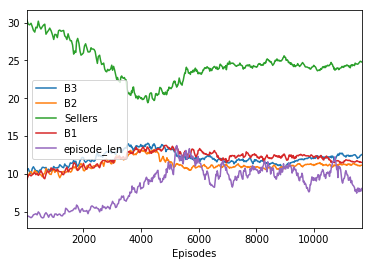

<Figure size 432x288 with 0 Axes>

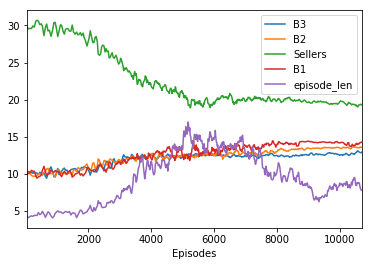

<Figure size 432x288 with 0 Axes>

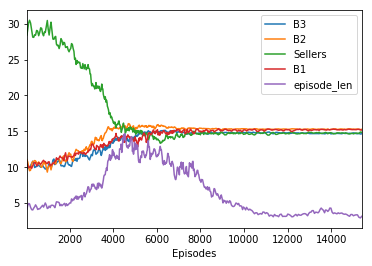

<Figure size 432x288 with 0 Axes>

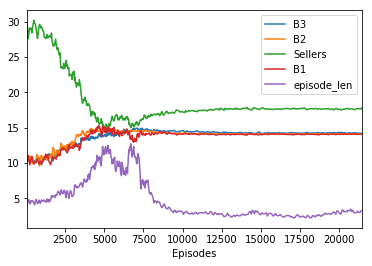

<Figure size 432x288 with 0 Axes>

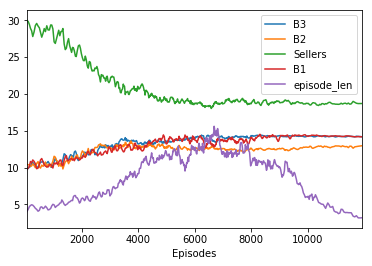

In [9]:
%%time
N_iter = 500
runs = 5
for i in range(runs):
    result = run_experiment(N_iter)
    plt.figure()
    result.plot()
    result.to_csv(f'{EXP_NAME}_iter{N_iter}_run{i}.csv')